<a href="https://www.kaggle.com/code/humagonen/amazon-reviews-sentiment-analysis-lstm?scriptVersionId=192814207" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer    # Tensorflow un Tokenizer fonksiyonu
from tensorflow.keras.preprocessing.sequence import pad_sequences    # modele vereceğimiz squence lerin aynı boyutta olmasını sağlıyor.

2024-08-15 21:56:52.511531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 21:56:52.511688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 21:56:52.645963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Read Data

converted train data from https://www.kaggle.com/datasets/bittlingmayer/amazonreviews/data to csv: 

https://www.kaggle.com/code/humagonen/data-conversion-from-bz2-to-csv

This dataset consists of 3.600.00M Amazon customer reviews

In [2]:
df = pd.read_csv('/kaggle/input/amazon-reviews-csv/amazon_reviews_train.csv')
df.head()

,label,text
0,0,Stuning even for the non-gamer: This sound tra...
1,0,The best soundtrack ever to anything.: I'm rea...
2,0,Amazing!: This soundtrack is my favorite music...
3,0,Excellent Soundtrack: I truly like this soundt...
4,0,"Remember, Pull Your Jaw Off The Floor After He..."


In [3]:
df.shape

(3600000, 2)

In [4]:
df.label.value_counts()

label
0    1800000
1    1800000
Name: count, dtype: int64

## Tokenization

In [5]:
X = df['text'].values
y = df['label'].values

In [6]:
num_words= 15000

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")  # oov_token="<OOV>"  to handle unseen tokens in test

In [7]:
tokenizer.fit_on_texts(X)

In [8]:
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'i': 4,
 'a': 5,
 'to': 6,
 'it': 7,
 'of': 8,
 'this': 9,
 'is': 10,
 'in': 11,
 'for': 12,
 'that': 13,
 'was': 14,
 'not': 15,
 'you': 16,
 'but': 17,
 'with': 18,
 'on': 19,
 'book': 20,
 'have': 21,
 'my': 22,
 'as': 23,
 'are': 24,
 'one': 25,
 'be': 26,
 'so': 27,
 'all': 28,
 'if': 29,
 'great': 30,
 'very': 31,
 'good': 32,
 'like': 33,
 'they': 34,
 'at': 35,
 'just': 36,
 'from': 37,
 'or': 38,
 'would': 39,
 'out': 40,
 'about': 41,
 'an': 42,
 'me': 43,
 'has': 44,
 'what': 45,
 'more': 46,
 'had': 47,
 'will': 48,
 'read': 49,
 'when': 50,
 "it's": 51,
 'get': 52,
 'no': 53,
 'up': 54,
 'by': 55,
 'time': 56,
 'there': 57,
 'only': 58,
 'your': 59,
 'can': 60,
 'movie': 61,
 'he': 62,
 'his': 63,
 "don't": 64,
 'really': 65,
 'some': 66,
 'do': 67,
 'well': 68,
 'than': 69,
 'them': 70,
 'who': 71,
 'much': 72,
 'even': 73,
 'first': 74,
 'other': 75,
 'we': 76,
 'these': 77,
 'her': 78,
 'after': 79,
 'love': 80,
 'because': 81,
 'buy'

In [9]:
X_num_tokens = tokenizer.texts_to_sequences(X)

In [11]:
X[100]

'textbook: Book shipped quickly and was in excellent condition as stated. Easy transaction would buy again'

In [12]:
print(X_num_tokens[100])

[2370, 20, 1246, 556, 3, 14, 11, 191, 854, 23, 1496, 169, 5755, 39, 82, 147]


In [13]:
reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}
word = reverse_word_index[2]
print(word)

the


In [14]:
num_tokens = [len(tokens) for tokens in X_num_tokens]  # X_num_tokens deki (yorumlardaki) her bir tokeni al ve say...
num_tokens = np.array(num_tokens)
num_tokens

array([ 80,  98, 130, ..., 183,  87, 141])

In [15]:
num_tokens.mean()

79.51119194444445

In [16]:
num_tokens.max()

257

In [17]:
num_tokens.argmax()

3071621

In [18]:
X[3071621]  # we can see the longest text from the index

'iLok is rubbish!!: I have never been able to get this worthless thing to work. $300 down the tubes! total WASTE!! RUBBISH CRAP!!! The worst part is the iLOK thing (worst idea ever!!) totally broke and now they want $50 bucks for a new one? I mean, it takes up an entire USB port so that it can run a license for one [crappy] program. As you can probably tell, I am not happy. Boycott!! DONT BUY!!! NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO'

In [19]:
len(num_tokens)

3600000

In [23]:
sum(num_tokens < 166) / len(num_tokens) 

0.9556658333333333

In [24]:
max_tokens = 166

In [25]:
sum(num_tokens < max_tokens) # 3.440.397 text rows have less than 166 tokens

3440397

In [26]:
sum(num_tokens > max_tokens)  # 150.880 text rows have more than 166 tokens

150880

## Padding

In [27]:
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)

In [28]:
X_pad.shape

(3600000, 166)

In [29]:
np.array(X_num_tokens[3071621]) # kisalarin basina 0 koyar

array([    1,    10,  3605,     4,    21,   122,    88,   323,     6,
          52,     9,  1389,   162,     6,    92,  2535,   164,     2,
        5974,   767,   196,  3605,   853,     2,   293,   254,    10,
           2,     1,   162,   293,   423,   132,   541,   560,     3,
         108,    34,   133,   795,  1312,    12,     5,   103,    25,
           4,   657,     7,   427,    54,    42,   568,  1260,  2605,
          27,    13,     7,    60,   547,     5,  6042,    12,    25,
        2524,   784,    23,    16,    60,   312,   404,     4,    98,
          15,   333, 11080,   523,    82,    53,    53,    53,    53,
          53,    53,    53,    53,    53,    53,    53,    53,    53,
          53,    53,    53,    53,    53,    53,    53,    53,    53,
          53,    53,    53,    53,    53,    53,    53,    53,    53,
          53,    53,    53,    53,    53,    53,    53,    53,    53,
          53,    53,    53,    53,    53,    53,    53,    53,    53,
          53,    53,

In [30]:
X_pad[3071621]

array([53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53], dtype=int32)

## train test split

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=0)

## Modeling

In [33]:
embedding_size = 50

In [34]:
max_tokens

166

In [35]:
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Embedding(input_dim=num_words,        # kelime uzayındaki toplam kelime sayısı
                    output_dim=embedding_size,  # her bir kelimemnin özellik sayısı
                    input_length = max_tokens))   # her bir dökümanda ki(yorum) kelime sayısı
 
model.add(Dropout(0.2))

# İlk gizli katman
model.add(Bidirectional(LSTM(units=48, return_sequences=True)))
model.add(Dropout(0.2))

# İkinci gizli katman
model.add(Bidirectional(LSTM(units=24, return_sequences=True)))
model.add(Dropout(0.2))

# Üçüncü gizli katman
model.add(Bidirectional(LSTM(units=12)))

model.add(Dense(1, activation='sigmoid'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
optimizer = Adam(learning_rate=0.01) 

In [37]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

In [38]:
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_recall", mode="max",   #mode= auto da trendi takip eder.             
                           verbose=1, patience = 2, restore_best_weights=True)

In [40]:
model.fit(X_train, y_train, 
          epochs=5, 
          batch_size=256,
          validation_data=(X_test, y_test), 
          callbacks=[early_stop])

Epoch 1/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 584s 51ms/step - Recall: 0.9098 - loss: 0.2169 - val_Recall: 0.9444 - val_loss: 0.1484
Epoch 2/5


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: Recall,loss,val_Recall,val_loss
  current = self.get_monitor_value(logs)


11250/11250 ━━━━━━━━━━━━━━━━━━━━ 578s 51ms/step - Recall: 0.9430 - loss: 0.1531 - val_Recall: 0.9436 - val_loss: 0.1507
Epoch 3/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 576s 51ms/step - Recall: 0.9421 - loss: 0.1551 - val_Recall: 0.9426 - val_loss: 0.1536
Epoch 4/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 574s 51ms/step - Recall: 0.9407 - loss: 0.1584 - val_Recall: 0.9407 - val_loss: 0.1573
Epoch 5/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 574s 51ms/step - Recall: 0.9388 - loss: 0.1624 - val_Recall: 0.9317 - val_loss: 0.1590


## Model Evaluation

In [41]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,Recall,loss,val_Recall,val_loss
0,0.933350,0.173142,0.944442,0.148441
1,0.942603,0.153982,0.943572,0.150681
2,0.941398,0.156720,0.942600,0.153624
3,0.939697,0.160261,0.940711,0.157321
4,0.938401,0.163165,0.931733,0.159034


<Axes: >

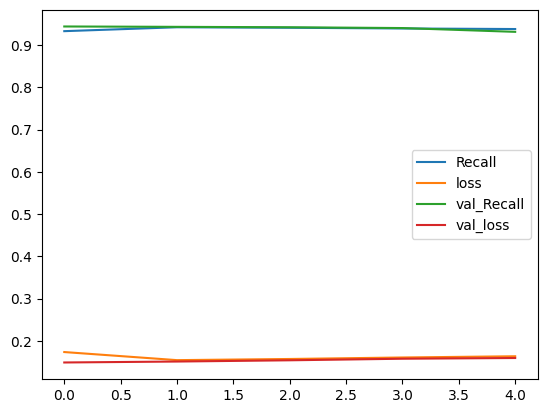

In [42]:
model_loss.plot()

In [56]:
model.evaluate(X_train, y_train)

90000/90000 ━━━━━━━━━━━━━━━━━━━━ 1349s 15ms/step - Recall: 0.9351 - loss: 0.1521


[0.1524147391319275, 0.9351076483726501]

In [57]:
model.evaluate(X_test, y_test)

22500/22500 ━━━━━━━━━━━━━━━━━━━━ 357s 16ms/step - Recall: 0.9320 - loss: 0.1593


[0.15903399884700775, 0.9317333102226257]

In [55]:
import gc
gc.collect()

846

In [59]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

90000/90000 ━━━━━━━━━━━━━━━━━━━━ 1217s 14ms/step
[[1366487   73513]
 [  93445 1346555]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.95      0.94   1440000
           1       0.95      0.94      0.94   1440000

    accuracy                           0.94   2880000
   macro avg       0.94      0.94      0.94   2880000
weighted avg       0.94      0.94      0.94   2880000



In [60]:
y_pred = model.predict(X_test) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

22500/22500 ━━━━━━━━━━━━━━━━━━━━ 314s 14ms/step
[[340728  19272]
 [ 24576 335424]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94    360000
           1       0.95      0.93      0.94    360000

    accuracy                           0.94    720000
   macro avg       0.94      0.94      0.94    720000
weighted avg       0.94      0.94      0.94    720000



22500/22500 ━━━━━━━━━━━━━━━━━━━━ 298s 13ms/step


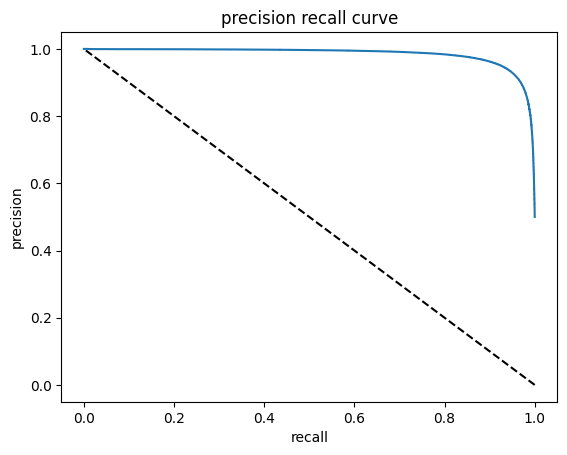

In [43]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba,)
plt.plot([1,0],[0,1],'k--')
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

In [44]:
average_precision_score(y_test, y_pred_proba)

0.9845339814893289

## Save Model and Tokenizer

In [46]:
model.save('review_amazon_sentiment5.h5')

In [47]:
import json

# Assuming tokenizer is already fitted on your training data
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)

## New text prediction

In [49]:
from tensorflow.keras.models import load_model

# load model
model_review = load_model('/kaggle/working/review_amazon_sentiment5.h5')

In [50]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

# Load the tokenizer JSON content as a string
with open('/kaggle/working/tokenizer.json', 'r') as f:
    data = json.load(f)  # This gives you a dictionary

# Convert the dictionary back to a JSON string
data_str = json.dumps(data)

# Use the string to load the tokenizer
tokenizer = tokenizer_from_json(data_str)

In [52]:
review1 = "I hated this product, never buying it again!"
review2 = "beautiful! fast shipping and a responsive seller"
review3 = "garbage product, no one should sell such thing"
review4 = "great price for a product like this, definitely buying it again"

reviews = [review1, review2, review3, review4]

In [53]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 15000
max_tokens = 166

tokens = tokenizer.texts_to_sequences(reviews)
tokens_pad = pad_sequences(tokens, maxlen=max_tokens)
tokens_pad.shape

(4, 166)

In [54]:
(model_review.predict(tokens_pad) >0.5).astype("int")  # WORKS PERFECTLY :) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


array([[1],
       [0],
       [1],
       [0]])

you can also check the related streamlit app from my github repo

## Thank You!